In [1]:
import timm
import torch
from PIL import Image
import numpy as np

In [2]:
model = timm.create_model("efficientnet_b0", num_classes=116)

In [3]:
trained_model = torch.load("efficientnet_b0_9982.pt", map_location=torch.device("cpu"))

In [4]:
model.load_state_dict(trained_model["model_state_dict"])

<All keys matched successfully>

In [5]:
with open("labels.txt") as f:
    prod = []
    for line in f.readlines():
        prod.append(line)

In [6]:
def infer(image_path,model):
   img = Image.open(image_path)
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      return prod[index].strip(), output

def infer_video(frame,model):
   frame = frame[256:812,512:1216,]
   img = Image.fromarray(np.uint8(frame)).convert('RGB')
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      return output.max(), frame, frame.mean()

def get_ratio(image):
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    return ratio

In [7]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [8]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

100%|██████████| 1799/1799 [00:28<00:00, 62.45it/s]


testA_1.mp4


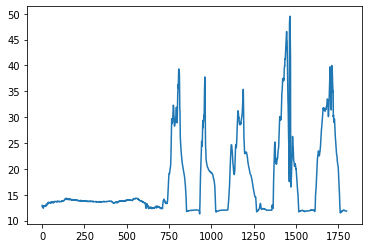

100%|██████████| 1499/1499 [00:24<00:00, 60.96it/s]


testA_2.mp4


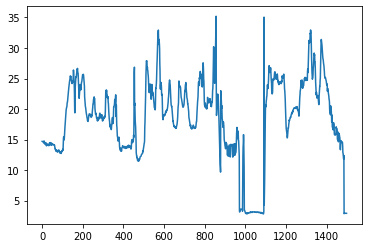

100%|██████████| 3642/3642 [01:10<00:00, 51.77it/s]


testA_3.mp4


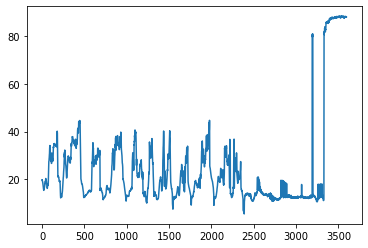

100%|██████████| 2123/2123 [00:41<00:00, 51.28it/s]


testA_4.mp4


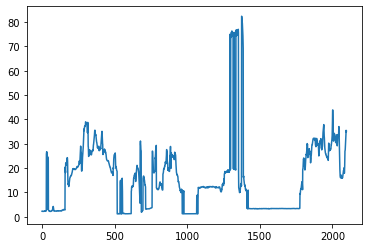

100%|██████████| 1547/1547 [00:28<00:00, 53.63it/s]


testA_5.mp4


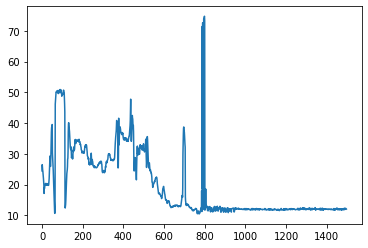

In [9]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

videos = ["testA_1.mp4","testA_2.mp4","testA_3.mp4","testA_4.mp4","testA_5.mp4",]
images_list = []
ratios_list = []

for video in videos:
  vidcap = cv2.VideoCapture(video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[256:896, 512:1400]
      image = automatic_brightness_and_contrast(image)
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []

  for img in resized_image:
    ratio = get_ratio(img)
    ratios.append(ratio)
  
  images_list.append(resized_image)
  ratios_list.append(ratios)

  print(video)
  plt.plot(ratios)
  plt.show()

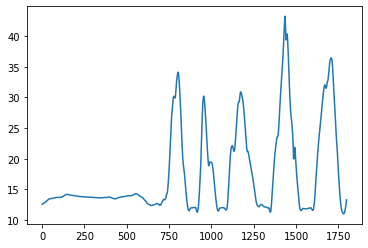

NEXT


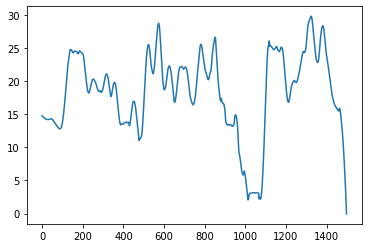

NEXT


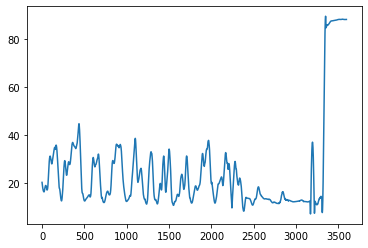

NEXT


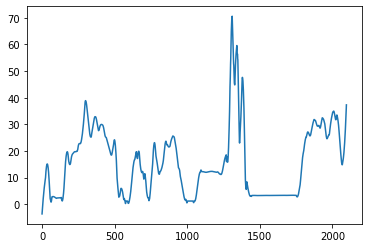

NEXT


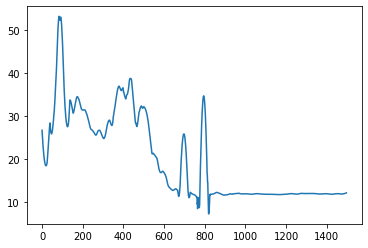

NEXT


In [10]:
from scipy.signal import savgol_filter, argrelextrema
images_with_object = []

count = 1
for images, ratios in zip(images_list, ratios_list):
    frames_with_object = []
    rolling_ratios = savgol_filter(ratios, 50, 2)
    maximas = argrelextrema(rolling_ratios, np.greater, order = 50)
    for maxima in maximas[0]:
        colorfulness = image_colorfulness(images[maxima])
        if(colorfulness>20):
            frames_with_object.append((images[maxima],maxima))
            count+=1
            # plt.imshow(images[maxima])
            # plt.show() 
    plt.plot(rolling_ratios)
    plt.show()
    print("NEXT")
    images_with_object.append(frames_with_object)

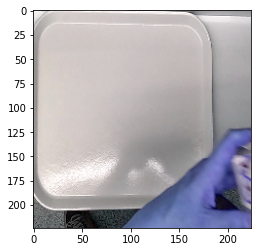

Total Home Scent Boos,106



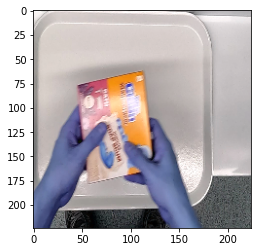

Nasacort Allergy,77



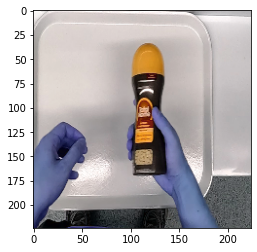

Nasacort Allergy,77



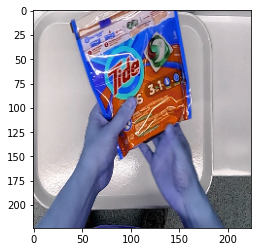

Tide Pods,103



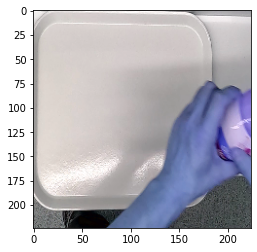

Total Home Scent Boos,106



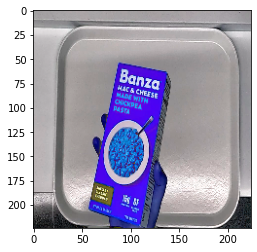

Dreft Scent Beads,37



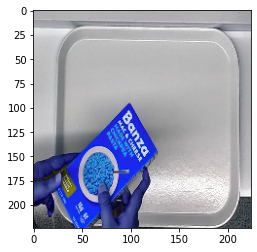

Dreft Scent Beads,37



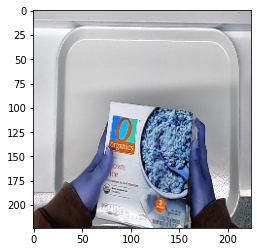

Banza,9



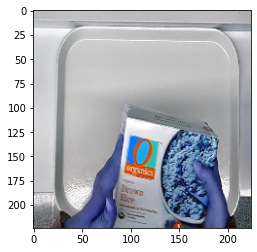

Brown Rice,18



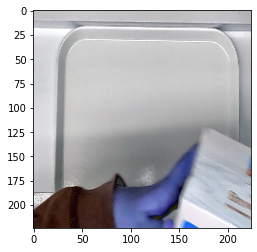

Miss Dior,71



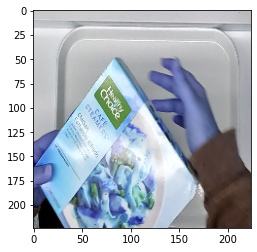

Healthy Choice Chicken Alfredo,54



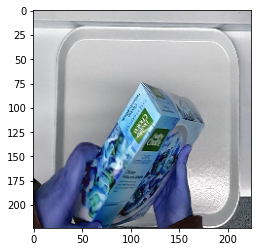

Healthy Choice Chicken Alfredo,54



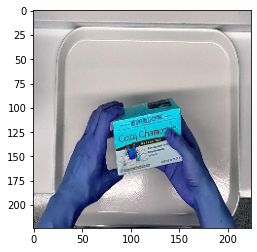

Dreft Scent Beads,37



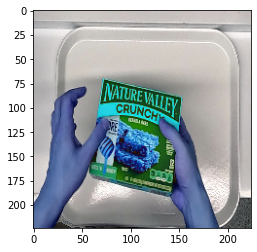

Nasacort Allergy,77



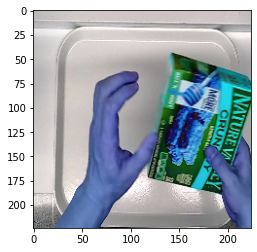

Nasacort Allergy,77



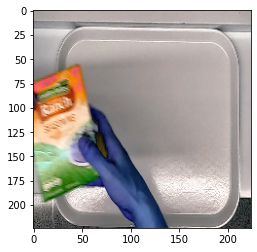

Dreft Scent Beads,37



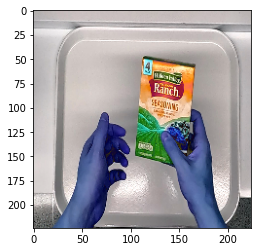

Nasacort Allergy,77



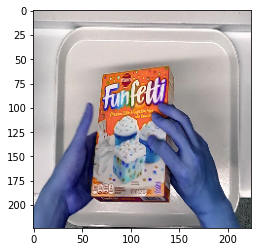

Nasacort Allergy,77



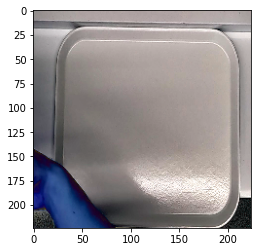

Dreft Scent Beads,37



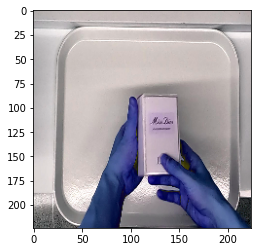

Woolite Delicates _Attempt_,116



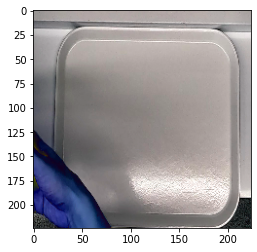

Dreft Scent Beads,37



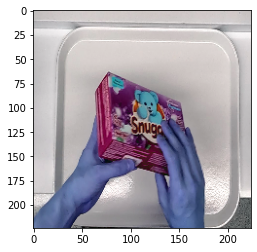

Woolite Delicates _Attempt_,116



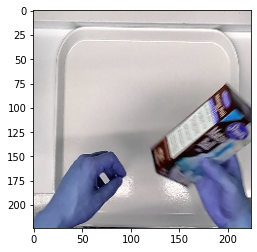

Nasacort Allergy,77



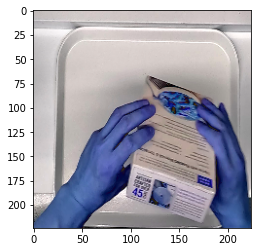

Nasacort Allergy,77



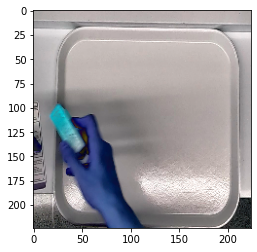

Dreft Scent Beads,37



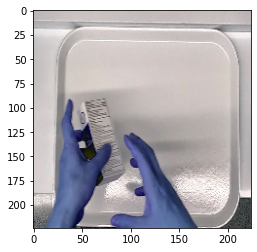

Dreft Scent Beads,37



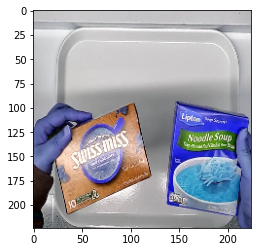

Nasacort Allergy,77



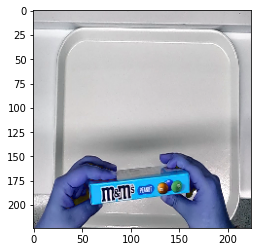

Nasacort Allergy,77



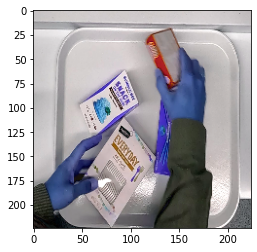

Nasacort Allergy,77



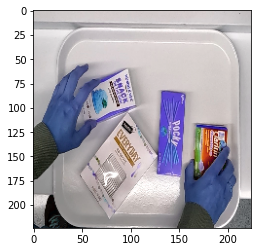

Nature Valley Granola Bars,80



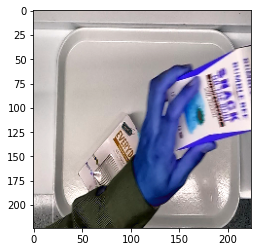

Children_s Allegra Allergy,23



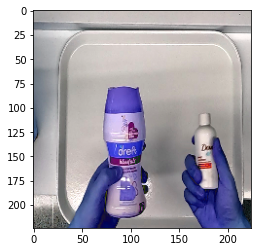

Nasacort Allergy,77



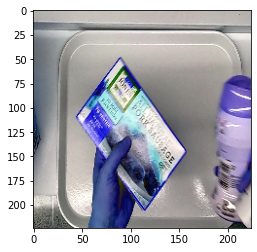

Dreft Scent Beads,37



In [16]:
def infer_frame(frame, model):
   img = Image.fromarray(frame).convert('RGB')
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      return output.data.cpu().numpy().argmax()+1

video_id = []
object_id = []
timestamp = []
for idx in range(len(images_with_object)):
    for image,frame in images_with_object[idx]:
         video_id.append(idx+1)
         object_id.append(infer_frame(image, model))
         plt.imshow(image)
         plt.show()
         print(prod[infer_frame(image,model)-1])
         timestamp.append(int(frame/60))

In [13]:
with open('submission.txt', 'w') as f:
    for vid, obj, tim in zip(video_id, object_id, timestamp):
        f.write(f'{vid} {obj} {tim}\n')
    f.close()